# Ramen Rating Analysis

### *Acknowledgement*
The data set is downloaded as-is from the original [The Big List](https://www.theramenrater.com/resources-2/the-list/) and then converted to a `.csv` file.

### Dataset Intro:

Each row in the dataset is a single ramen product review.

**Variables:**

- `Review #`: contiguous numbers, more recently reviewed ramen have higher numbers<br>
- `Brand`: brand names<br>
- `Variety`: product name, containing ingredients<br>
- `Style`: i.e. cup, bowl, tray, or restaurant? <br>
- `Country`: produced from which country produce <br>
- `Stars`: ratings on a 5-point scale (0 - worest, and 5 - best)<br>
- `Top Ten`: null when not on any Top Ten list; otherwise year+ranking (not complete)

### Purpose of the Project

To practice `preprocessing` (missing data, invalid entries, etc.), and be able to answer the **`following questions`**:<br>
1. The top 5 brands, styles, and countries that have the most Top Ten 
2. The top brands, styles, and countries that have the highest average ratings.

To also practice creating `bag of words` and `WordCloud`, and be able to identify **the most frequently used ingredients.**

## Preprocess the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
reviews = pd.read_csv('ramen-ratings.csv')

In [3]:
reviews.head(10)

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2816,Nissin,Top Ramen Hot Spicy Beef Ramen Noodle Soup,Pack,United States,3,NaN
1,2815,Sapporo Ichiban,Pokemon Shoyu Ramen,Cup,Japan,3.5,NaN
2,2814,Little Couples Q Noodle,Taiwan Sauce Taste,Pack,Taiwan,4.5,NaN
3,2813,Little Couples Q Noodle,Oyster Sauce Taste,Pack,Taiwan,3.5,NaN
4,2812,Little Couples Q Noodle,Fried Garlic Taste,Pack,Taiwan,5,NaN
5,2811,Little Couples Q Noodle,Taiwan Soybean Taste,Pack,Taiwan,2.75,NaN
6,2810,Little Couples Q Noodle,Spicy Taste,Pack,Taiwan,3.75,NaN
7,2809,Acecook,Shrimp Tempura Soba,Cup,Japan,0.5,NaN
8,2808,Super,Super Cup Signature White Curry,Cup,Malaysia,0.25,NaN
9,2807,Maruchan,Gotsumori Shio Wonton Ramen,Bowl,Japan,5,NaN


In [4]:
print('There are {} rows and {} columns in the data set'.format(reviews.shape[0],\
                                                                reviews.shape[1]))

There are 2816 rows and 7 columns in the data set


### 1. Check for Invalid Values in each Column

In [5]:
def colUniqueValues():
    for col in reviews.columns:
        print(col, 'has', len(reviews[col].unique()),'unique values\n')
        if len(reviews[col].unique()) < 60:
            print('The unique values for column', col, 'are listed as below:\n',\
                  reviews[col].unique(), '\n')
        
colUniqueValues()

Review # has 2816 unique values

Brand has 388 unique values

Variety has 2631 unique values

Style has 9 unique values

The unique values for column Style are listed as below:
 ['Pack' 'Cup' 'Bowl' 'Tray' 'Box' 'Restaurant' 'Can' 'Bar' nan] 

Country has 39 unique values

The unique values for column Country are listed as below:
 ['United States' 'Japan' 'Taiwan' 'Malaysia' 'Hong Kong' 'Indonesia'
 'South Korea' 'Thailand' 'Poland' 'Singapore' 'China' 'USA' 'Vietnam'
 'Canada' 'India' 'Phlippines' 'Nigeria' 'Ghana' 'Germany' 'Hungary'
 'Mexico' 'Fiji' 'Australia' 'Pakistan' 'Bangladesh' 'Nepal' 'Brazil' 'UK'
 'Myanmar' 'Netherlands' 'Cambodia' 'Finland' 'Sarawak' 'Philippines'
 'Sweden' 'Colombia' 'Estonia' 'Holland' 'Dubai'] 

Stars has 56 unique values

The unique values for column Stars are listed as below:
 ['3' '3.5' '4.5' '5' '2.75' '3.75' '0.5' '0.25' '4.25' '1.5' '4' '2'
 '3.25' '4.75' '0' '5-Jan' '3-Jan' '4-Jan' '2.25' '1' 'NR' '3.5/2.5'
 '4-Apr' '5-May' '4.5/5' '5/2.5' '4-Ma

The above printout is helpful to scan for possible invalid entries in each column.<br>
It appears that `Stars` and `Top Ten` have some invalid values:<br>
- `Stars`: Date, 'NR', 'Unrated', '4.5/5
- `Top Ten`: NaN, '\n'

In [33]:
# Correct two typos in Country column
reviews.replace({'USA': 'United States', 'Phlippines':'Philippines'}, inplace =True)

### 2. The Number of Missing Values in each Column

In [7]:
missValues = pd.DataFrame(reviews.isnull().sum(), columns = ['Count'])
missValues

,Count
Review #,0
Brand,0
Variety,0
Style,2
Country,0
Stars,0
Top Ten,2775


After examing the data further, it's expected to have many missing data in the `Top Ten` column, <br>
but the 2 missing values in the `Style` column is unexpected and, in fact, can be easily identified 
as Pack.<br> Therefore, assigning them with a value is reasonable here. 

In [8]:
# To assign values to missing values in Styles
reviews.loc[:, 'Style'].fillna('Pack', inplace = True)

In [9]:
# To ensure the Style column does NOT have missing values anymore
missValues = pd.DataFrame(reviews.isnull().sum(), columns = ['Count'])
missValues

,Count
Review #,0
Brand,0
Variety,0
Style,0
Country,0
Stars,0
Top Ten,2775


### 3. Distribution of *Stars* Column

In [10]:
# To ensure the data type of Stars column is numeric for futher analysis
print('The data type of Stars column is {}'.format(reviews.Stars.dtype))

The data type of Stars column is object


#### 3.1 Convert *Star* to Float

The original `dtype` for `Stars` is `Object (Str)`. 
Even though **Stars** column has NO missing data, <br>
not all value are numbers (i.e. date, NR, 4.5/5, Unrated, etc.). 
Therefore, when convert this column to numeric type, <br>
`to_numeric()` should be choosen over `astype()` for the following reason.

#### *`astype()`* vs *`to_numeric()`*

- Using `astype()` method for numeric values stored as strings. <br>
Specifically, if values have already had dtypes (i.e. int8/16/32/64, float64, or boolean),<br> 
and will be converted to another *numeric* dtype.
- Using `to_numeric()` for numeric and non-numeric values.

**Note:** 
- [When to use astype() and to_numeric()](https://stackoverflow.com/questions/40095712/when-to-applypd-to-numeric-and-when-to-astypenp-float64-in-python). <br>
- [Convert string to numeric](https://datatofish.com/convert-string-to-float-dataframe/)
   

In [11]:
# By setting errors=’coerce’, the non-numeric values will be transformed into NaN.
reviews['Stars'] = pd.to_numeric(reviews['Stars'],errors='coerce')

# Therefore, there should be some missing values in Stars column
print('There are {} missing values in Stars column'.\
      format(reviews.Stars.isnull().sum()))

There are 21 missing values in Stars column


In [12]:
# Drop all rows that have missing value in the Stars column
reviews.dropna(subset=['Stars'], inplace = True)

In [13]:
# Statistics of Stars Column
pd.DataFrame(reviews.Stars.describe())

,Stars
count,2795.000000
mean,3.675027
std,1.030433
min,0.000000
25%,3.250000
50%,3.750000
75%,4.250000
max,5.000000


#### 3.2 Histogram of *Star* Column

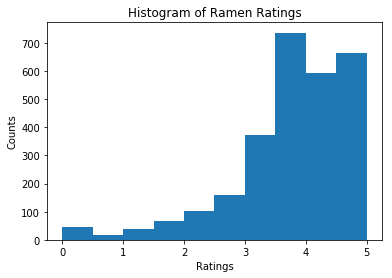

In [14]:
plt.hist(reviews.Stars)
plt.xlabel('Ratings')
plt.ylabel('Counts')
plt.title('Histogram of Ramen Ratings')
plt.show()

### 4. Remove Empty Strings from the Data Set

The `Top Ten` column has several entries that are `\n` due to `wrap text` setting 
in the original `.csv` file. <br>If not removed, those entries would be counted
when using `count()` in Python.

In [15]:
# Before Remove
reviews[reviews.Brand == 'Indomie'].tail()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
2768,48,Indomie,Shrimp Flavor,Pack,Indonesia,3.00,NaN
2769,47,Indomie,Mi Goreng Jumbo Barbecue Chicken,Pack,Indonesia,5.00,2012 #2
2770,46,Indomie,Mi Goreng Jumbo Meatball,Pack,Indonesia,3.00,NaN
2771,45,Indomie,Mi Goreng Sate,Pack,Indonesia,5.00,\n
2772,44,Indomie,Special Chicken,Pack,Indonesia,4.25,NaN


In [16]:
# Remove \n
reviews['Top Ten'].replace('\n', np.nan, inplace = True)

In [17]:
# After Remove
reviews[reviews.Brand == 'Indomie'].tail()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
2768,48,Indomie,Shrimp Flavor,Pack,Indonesia,3.00,NaN
2769,47,Indomie,Mi Goreng Jumbo Barbecue Chicken,Pack,Indonesia,5.00,2012 #2
2770,46,Indomie,Mi Goreng Jumbo Meatball,Pack,Indonesia,3.00,NaN
2771,45,Indomie,Mi Goreng Sate,Pack,Indonesia,5.00,NaN
2772,44,Indomie,Special Chicken,Pack,Indonesia,4.25,NaN


In [18]:
# Rest the index to have continous index number
new_index = np.arange(len(reviews))
reviews = reviews.reset_index(drop=True)

## Top 5 *Brand, Country, and Style*  that have the most *Top Ten*

In [19]:
for col in ['Brand', 'Country', 'Style']:
    print('Top 5 {} that have the most Top Ten'.format(col))
    
    topTen = pd.DataFrame(reviews.groupby(by = col).count()\
    .sort_values(by = 'Top Ten', ascending = False)['Top Ten'].head())
    
    print(topTen, '\n')

Top 5 Brand that have the most Top Ten
             Top Ten
Brand               
Prima Taste        5
MyKuali            3
Mama               3
Nongshim           3
Indomie            3 

Top 5 Country that have the most Top Ten
             Top Ten
Country             
Singapore          7
Japan              6
Malaysia           6
South Korea        5
Indonesia          4 

Top 5 Style that have the most Top Ten
       Top Ten
Style         
Pack        33
Tray         4
Bar          0
Bowl         0
Box          0 



## Top 5 *Brand, Country, and Style* that have Highest Average Rating

**Note**: Without considering the `sample size`

In [35]:
for col in ['Country', 'Style', 'Brand']:
    print('Top 5 {} that have highest average rating'.format(col))
    
    avgRating = pd.DataFrame(round(reviews.drop(columns='Review #').groupby(by=col).mean(),2)\
          .sort_values(by = 'Stars', ascending = False).head(5))
    
    print(avgRating, '\n')

Top 5 Country that have highest average rating
           Stars
Country         
Brazil      4.35
Sarawak     4.33
Cambodia    4.20
Malaysia    4.16
Singapore   4.11 

Top 5 Style that have highest average rating
            Stars
Style            
Bar          5.00
Restaurant   4.75
Box          4.28
Can          4.00
Pack         3.73 

Top 5 Brand that have highest average rating
               Stars
Brand               
Qinsheng         5.0
Plats Du Chef    5.0
TTL              5.0
Song Hak         5.0
ChoripDong       5.0 



However, the above average is quite naive as the analysis didn't take<br> the number of cases in each variable into account. <br>For instance, `Brazil` is the top 1 country that has the highest average rating,<br>but it might be because there is only one case for `Brazil`, which has a rating of 4.35.<br>Comparing with countries that have much more instances, the average would be discriminated. <br> Therefore, only variables that have `more than 100 instances` would be considerred here. 

## Top *Brand, Country, and Style* that have Highest Average Rating

**Note:** After considering the `sample size`

In [36]:
for col in ['Brand', 'Country', 'Style']:
    df = pd.DataFrame(reviews.groupby(by = col).count()\
                      .sort_values(by = 'Stars', ascending = False))
    df = df[df.Stars > 100]
    lst = df.index.values
    Dict = {}
    for row in range(len(lst)):
        newDF = reviews[reviews[col]==lst[row]]
        Dict[lst[row]] =  round(newDF.Stars.mean(),2)
        rating = pd.DataFrame.from_dict(Dict, orient='index', columns = ['Stars'])\
                .sort_values(by = 'Stars',ascending = False ).head()
    print('Top', len(rating), '{} that have highest average rating'.format(col))
    print(rating,'\n')

Top 2 Brand that have highest average rating
          Stars
Nongshim   4.03
Nissin     3.95 

Top 5 Country that have highest average rating
           Stars
Malaysia    4.16
Singapore   4.11
Indonesia   4.08
Japan       3.96
Hong Kong   3.83 

Top 4 Style that have highest average rating
      Stars
Pack   3.73
Bowl   3.68
Tray   3.63
Cup    3.50 



## Bag of Words

In [22]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mumudreamer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### To be familar with the labels styles:

In [23]:
reviews.Variety.tail(15)

2780                                   Pojangmacha U-dong
2781                                                  Hot
2782                                            Chow Mein
2783                                        Shrimp Flavor
2784                   Chicken Flavor Instant Soup Noodle
2785                                       Vegetable Beef
2786                                           Cup Noodle
2787                     Chinese Beef Instant Rice Noodle
2788                                        Mushroom Pork
2789                                             Nam Vang
2790    Hu Tiu Nam Vang ["Phnom Penh" style] Asian Sty...
2791                       Oriental Style Instant Noodles
2792                                       Tom Yum Shrimp
2793                                 Tom Yum Chili Flavor
2794                                           Miso Ramen
Name: Variety, dtype: object

In [24]:
print('The data type of Variety column is {}'.format(reviews.Variety.dtype))

The data type of Variety column is object


### To Create the Corpus

In [25]:
corpus = []
for i in range(len(reviews)):
    ingredients = re.sub('[^a-zA-Z]', ' ', reviews['Variety'][i])
    ingredients = ingredients.lower().split()
    ps = PorterStemmer()
    ingredients = [ps.stem(word) for word in ingredients \
                   if not word in set(stopwords.words('english'))]
    ingredients = ' '.join(ingredients)
    corpus.append(ingredients)
corpus

['top ramen hot spici beef ramen noodl soup',
 'pokemon shoyu ramen',
 'taiwan sauc tast',
 'oyster sauc tast',
 'fri garlic tast',
 'taiwan soybean tast',
 'spici tast',
 'shrimp tempura soba',
 'super cup signatur white curri',
 'gotsumori shio wonton ramen',
 'cup noodl light seafood flavour',
 'umaitsuyu tempura soba',
 'chines style yakisoba',
 'curri flavour instant noodl',
 'cup noodl black pepper crab flavour potato chip',
 'ippei chan yomis yakisoba barbequ sauc flavor mayonnais',
 'origin beef flavor noodl',
 'kitsun soba',
 'instant noodl mi goreng fri noodl taiwan version',
 'chikin ramen shoyu flavor',
 'beef pho flavor rice noodl soup',
 'pork tonkotsu flavor ramen soup',
 'vegetarian kimchi flavor ramen soup',
 'chicken flavor ramen soup',
 'spici pork tonkotsu flavor ramen soup',
 'vegetarian veget ramen soup',
 'savori miso flavor ramen soup',
 'spici beef flavor ramen soup',
 'fri garlic chicken flavor ramen soup',
 'mala buldak bokkeummyun',
 'supercup big pork kimch

### To Create the Bag of Wrods

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
cv = CountVectorizer(max_features = 1350)
X = cv.fit_transform(corpus).toarray()
pd.DataFrame(X).tail()

,0,1,2,3,4,5,6,7,8,9,...,1340,1341,1342,1343,1344,1345,1346,1347,1348,1349
2790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2792,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2793,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## WordCloud 

### To identify ingredients that are used most frequently

In [28]:
#import sys
#!{sys.executable} -m pip install wordcloud

In [29]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [30]:
ingredient = reviews.Variety
text = " ".join(words for words in ingredient)
print ("There are {} words in the combination of all Variety.".format(len(text)))

There are 85797 words in the combination of all Variety.


In [31]:
ramen_mask = np.array(Image.open("ramen.png"))

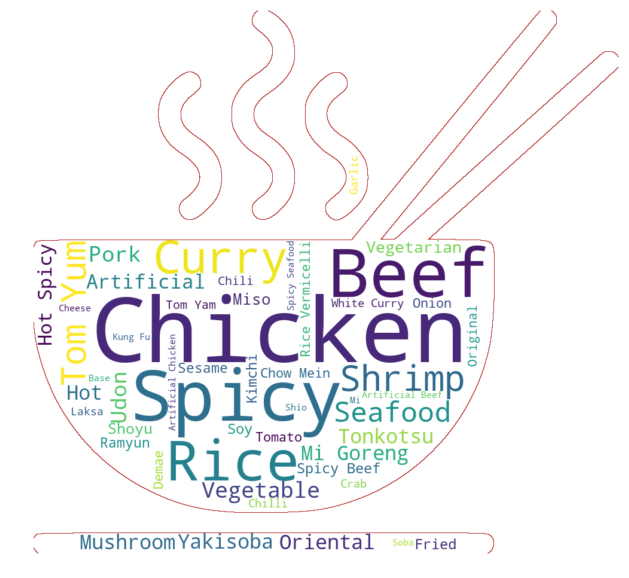

In [32]:
stopwords = set(STOPWORDS)
stopwords.update(["noodle", "cup", "ramen", "flavor", "instant Noodle", \
                  'flavour', 'instant', 'noodles','Soup','Sauce', 'bowl',\
                 'style','king','big','black','super','japanese'])

# Create a word cloud image
wc = WordCloud(background_color="white",stopwords=stopwords,max_font_size=150,\
               max_words=50,mask=ramen_mask,contour_width=1,contour_color='firebrick')

# Generate a wordcloud
wc.generate(text)

# store to file
wc.to_file("wordcloud.png")

# show the picture
plt.figure(figsize=[25,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Some Takeaways

1. **Always check for invalid entires on top of missing values.** <br> Some invalid values (i.e. whitespace) will not be identified or counted as missing value,<br> however those values might cause runtime error later on if not taken care of.
2. **After remove all rows with null values using dropna(inplace=True), the index of the dataframe will not change.**<br> Specifically, two rows with index 75 and 76 had null values and they were dropped after ran dropna(inplace=T). <br> However, because the original dataframe will not be reindexed, the dataframe will be missing index 75 and 76.<br> When ran a for loop with the range of length of the dataframe, it will iterate to an index that no longer exists.<br> Therefore, reset the index is critical.  